In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

### Resampling

In [3]:
session_times = pd.read_csv("https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/web_page_data.csv")
session_times.Time = 100 * session_times.Time

In [14]:
print(session_times.groupby(by="Page").count())
print()
session_times.head(4)

        Time
Page        
Page A    21
Page B    15



,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0


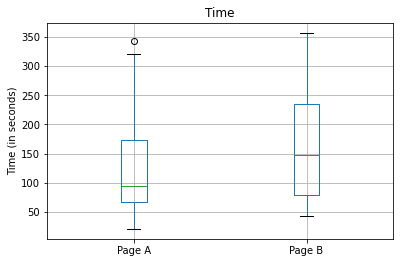

In [6]:
ax = session_times.boxplot(by="Page", column="Time")
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

In [12]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
mean_b - mean_a

35.66666666666667

Page B has session time greater than Page A by 35.67 seconds on average. But the question is whether this difference is within the range of what random chancne might produce i.e. statistically insignificant.  
Let's apply permutation test - combine all sessions times together and then repeatedly shuffle and divide them into groups of 21 (as ${n_A}=21$) and 15 (as ${n_B}=15$)

In [32]:
def permute(x, na, nb):
    n = na+nb
    idx_B = set(random.sample(range(n), nb)) #Sampling without replacement
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

na = session_times[session_times.Page=="Page A"].shape[0]
nb = session_times[session_times.Page=="Page B"].shape[0]

print(permute(session_times.Time, na, nb))

35.09523809523809


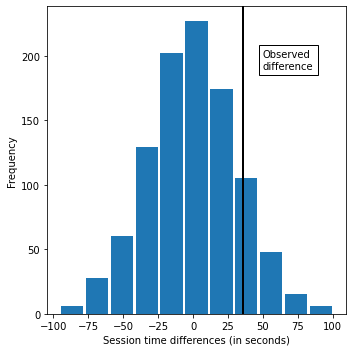

In [33]:
random.seed(1)
perm_diffs = [ permute(session_times.Time, na, nb) for _ in range(1000) ]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
print(np.mean(np.array(perm_diffs) > (mean_b - mean_a)))

0.121


So mean difference of random permutations often exceeds the observed difference in session times (vertical line). For our result, this happens in 12.1% of the cases.  
Thus suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.